In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                         validation_split=.2,
                                                         horizontal_flip=True,
                                                         rotation_range=20)

In [14]:
example = datagen.flow_from_directory('./lfw-funneled/', class_mode='input').__next__()

Found 13233 images belonging to 1 classes.


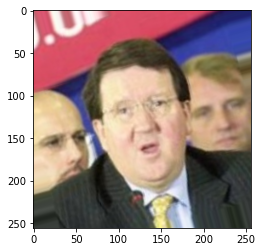

In [27]:
plt.imshow(example[0][1])

In [322]:
input_layer = tf.keras.layers.Input((256,256,3))
conv1_a = tf.keras.layers.Conv2D(3, 3, strides=2, activation='relu')(input_layer)
max_pool1 = tf.keras.layers.MaxPool2D(name='maxpool1')(conv1_a)
conv2_a = tf.keras.layers.Conv2D(16, 3, strides=2, activation='relu')(max_pool1)
#max_pool2 = tf.keras.layers.MaxPool2D()(conv2_a)
flatten = tf.keras.layers.Flatten()(conv2_a)
latent = tf.keras.layers.Dense(1024, activation='sigmoid', name='latent')(flatten)
dense1_b = tf.keras.layers.Dense(3072, activation='relu')(latent)
reshape = tf.keras.layers.Reshape((32,32,3))(dense1_b)
conv1_b = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, activation='relu')(reshape)
upsample2_b = tf.keras.layers.UpSampling2D(size=2)(conv1_b)
conv2d_b = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, activation='sigmoid')(upsample2_b)
crop = tf.keras.layers.Cropping2D(5)(conv2d_b)

In [323]:
ae = tf.keras.models.Model(inputs=input_layer, outputs=crop, name='AE')
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 127, 127, 3)       84        
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 63, 63, 3)         0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 31, 31, 16)        448       
_________________________________________________________________
flatten_45 (Flatten)         (None, 15376)             0         
_________________________________________________________________
latent (Dense)               (None, 1024)              15746048  
_________________________________________________________________
dense_97 (Dense)             (None, 3072)              3148800  

In [317]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_7-24.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [318]:
train_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='training', class_mode='input', color_mode='rgb')
test_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='validation', class_mode='input', color_mode='rgb')

Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


((256, 256, 3), (256, 256, 3))

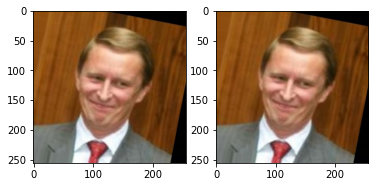

In [319]:
val = test_generator.__next__()
plt.subplot(121)
plt.imshow(val[0][0])
plt.subplot(122)
plt.imshow(val[1][0])
(val[0][0].shape, val[1][0].shape)

In [320]:
tf.config.list_physical_devices('GPU')

[]

In [325]:
ae.fit(train_generator, batch_size=128,
      validation_data=test_generator, initial_epoch=15,
      epochs=30, callbacks=[early_stop, checkpoint])

Epoch 16/30
381/381 [==============================] - ETA: 0s - loss: 0.0514
Epoch 00016: val_loss did not improve from 0.00943
381/381 [==============================] - 427s 1s/step - loss: 0.0514 - val_loss: 0.0323
Epoch 17/30
381/381 [==============================] - ETA: 0s - loss: 0.0276
Epoch 00017: val_loss did not improve from 0.00943
381/381 [==============================] - 461s 1s/step - loss: 0.0276 - val_loss: 0.0227
Epoch 18/30
381/381 [==============================] - ETA: 0s - loss: 0.0192
Epoch 00018: val_loss did not improve from 0.00943
381/381 [==============================] - 454s 1s/step - loss: 0.0192 - val_loss: 0.0176
Epoch 19/30
381/381 [==============================] - ETA: 0s - loss: 0.0166
Epoch 00019: val_loss did not improve from 0.00943
381/381 [==============================] - 450s 1s/step - loss: 0.0166 - val_loss: 0.0152
Epoch 20/30
381/381 [==============================] - ETA: 0s - loss: 0.0152
Epoch 00020: val_loss did not improve from 0.0

KeyboardInterrupt: 

In [305]:
tf.keras.models.save_model(ae, 'best_7-24.h5')

(256, 256, 3)

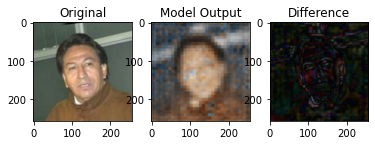

In [307]:
img = np.array(val[0][14])
img_reshaped = img.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped)
plt.subplot(131)
plt.title('Original')
plt.imshow(img)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img-prediction[0]))
img.shape

In [285]:
encoder = tf.keras.models.Model(inputs=input_layer, outputs=ae.get_layer(name='latent').output)
encoder.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 127, 127, 3)       84        
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 63, 63, 3)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 31, 31, 16)        448       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 3600)              0         
_________________________________________________________________
latent (Dense)               (None, 256)               921

In [286]:
coding_vector = encoder.predict(img_reshaped)
coding_vector

array([[0.41447031, 0.36400494, 0.28142637, 0.19334915, 0.39098442,
        0.45840126, 0.5915606 , 0.32837576, 0.05309853, 0.00957632,
        0.2515425 , 0.37944874, 0.20442429, 0.49183667, 0.02166632,
        0.34769353, 0.06901142, 0.11926541, 0.13596377, 0.442705  ,
        0.32271564, 0.8938266 , 0.25527057, 0.2907401 , 0.37205982,
        0.02647439, 0.40136123, 0.37120467, 0.24556643, 0.5910669 ,
        0.35664302, 0.2240932 , 0.3063534 , 0.368618  , 0.34151804,
        0.3700504 , 0.26194954, 0.59603286, 0.30281603, 0.00501275,
        0.5689029 , 0.04640919, 0.46052998, 0.01926205, 0.00357562,
        0.306148  , 0.17039478, 0.37573227, 0.24485868, 0.3751312 ,
        0.64051276, 0.3539771 , 0.07957315, 0.44882327, 0.46457002,
        0.4671204 , 0.48775387, 0.17665353, 0.46288678, 0.04457304,
        0.02450132, 0.56783104, 0.03187516, 0.33229086, 0.61460483,
        0.24516356, 0.5925004 , 0.52549416, 0.21897867, 0.3751309 ,
        0.25456214, 0.8296325 , 0.38371077, 0.33

(256, 256, 3)

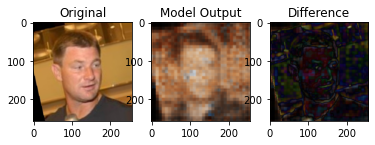

In [293]:
img2 = np.array(val[0][8])
img_reshaped2 = img2.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped2)
plt.subplot(131)
plt.title('Original')
plt.imshow(img2)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img2-prediction[0]))
img2.shape

In [288]:
coding_vector2 = encoder.predict(img_reshaped2)
coding_vector2

array([[0.4761842 , 0.43570516, 0.43416527, 0.17875507, 0.5114434 ,
        0.2239067 , 0.34228534, 0.42326075, 0.16865933, 0.03983992,
        0.2833717 , 0.3215335 , 0.3429168 , 0.3093089 , 0.01951453,
        0.593413  , 0.12488768, 0.43774286, 0.26320583, 0.5702418 ,
        0.7643193 , 0.7211385 , 0.41211596, 0.7270837 , 0.31586114,
        0.11485699, 0.14572427, 0.33882618, 0.39792645, 0.8085699 ,
        0.3926203 , 0.6735614 , 0.48920298, 0.7034707 , 0.23835853,
        0.7066568 , 0.29839528, 0.69967127, 0.46813345, 0.0056183 ,
        0.37399867, 0.28837755, 0.47060832, 0.01839751, 0.00476706,
        0.42892247, 0.4512389 , 0.75360966, 0.5344202 , 0.3882942 ,
        0.6999769 , 0.44554985, 0.13809758, 0.5702612 , 0.64790154,
        0.5814303 , 0.46257365, 0.18724525, 0.22100204, 0.16659087,
        0.10172915, 0.4458779 , 0.08630133, 0.23993582, 0.2528298 ,
        0.39033172, 0.40095085, 0.4016239 , 0.3549075 , 0.5527107 ,
        0.24859911, 0.5743207 , 0.58058137, 0.75

In [290]:
np.mean(coding_vector - coding_vector2)

-0.047534354